
# Case Study 5: Bayesian Neural Network

Adapted from https://num.pyro.ai/en/stable/examples/bnn.html , we first see the NumPyro implementation and then SOGA.


In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

In [6]:
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
torch.set_default_dtype(torch.float32)



# the non-linearity we use in our neural network
def nonlin(x):
    return F.relu(x)


def model(X, Y, D_H, D_Y=1):
    D_X = 1
    N = X.shape[0]

    # Sample first layer weights and biases
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(D_X, D_H, dtype=torch.float32), torch.ones(D_X, D_H, dtype=torch.float32)))
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(D_H, dtype=torch.float32), torch.ones(D_H, dtype=torch.float32)))
    z1 = nonlin(torch.matmul(X, w1) + b1)  # First layer activations

    # Sample second layer weights and biases
    #w2 = pyro.sample("w2", dist.Normal(torch.zeros(D_H, D_H, dtype=torch.float32), torch.ones(D_H, D_H, dtype=torch.float32)))
    #b2 = pyro.sample("b2", dist.Normal(torch.zeros(D_H, dtype=torch.float32), torch.ones(D_H, dtype=torch.float32)))
    #z2 = nonlin(torch.matmul(z1, w2) + b2)  # Second layer activations

    # Sample final layer weights and biases
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(D_H, D_Y, dtype=torch.float32), torch.ones(D_H, D_Y, dtype=torch.float32)))
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(D_Y, dtype=torch.float32), torch.ones(D_Y, dtype=torch.float32)))
    z3 = torch.matmul(z1, w3) + b3  # Final output of the neural network

    # Observation noise (fixed for simplicity)
    sigma_obs = torch.tensor(0.1, dtype=torch.float32)

    # Observe data
    pyro.sample("Y", dist.Normal(z3.squeeze(1), sigma_obs), obs=Y)


# helper function for HMC inference
def run_inference(model, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_samples=2000,
        warmup_steps=500,
        num_chains=1,
    )
    mcmc.run(X, Y, D_H)
    mcmc.summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# helper function for prediction
def predict(model, samples, X, D_H):
    predictive = Predictive(model, samples)
    predictions = predictive(X, None, D_H)["Y"]
    return predictions


# create artificial regression dataset
# Ensure all tensors are of dtype torch.float32
def get_data(N=20, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, np.newaxis], np.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, np.newaxis], np.arange(D_X))

    # Convert all tensors to float32
    return (
        torch.tensor(X[:, 1:2], dtype=torch.float32),
        torch.tensor(Y, dtype=torch.float32),
        torch.tensor(X_test[:, 1:2], dtype=torch.float32),
    )

args = [10, 2, 2]
N, D_X, D_H = args
X, Y, X_test = get_data(N=N, D_X=D_X)
Y = Y.squeeze()
#X = X.squeeze()
X_test = X_test.squeeze()
# do inference
samples = run_inference(model, X, Y, D_H)



Sample: 100%|██████████| 2500/2500 [02:45, 15.07it/s, step size=3.20e-02, acc. prob=0.940]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]     -2.25      0.27     -2.24     -2.66     -1.80    470.97      1.00
     b1[1]      0.19      0.12      0.18      0.02      0.38    592.01      1.01
     b3[0]     -0.33      0.05     -0.33     -0.41     -0.25    959.30      1.01
   w1[0,0]      3.57      0.41      3.55      2.86      4.20    474.01      1.00
   w1[0,1]      1.97      0.50      1.91      1.19      2.79    778.37      1.00
   w3[0,0]     -4.08      0.48     -4.05     -4.89     -3.31    569.30      1.00
   w3[1,0]      1.77      0.47      1.70      0.98      2.43    687.77      1.00

Number of divergences: 0

MCMC elapsed time: 165.95113801956177


In [7]:
# predict Y_test at inputs X_test
predictions = predict(model, samples, X, D_H)

# compute mean prediction and confidence interval around median
mean_prediction = predictions.mean(0).detach().numpy()
percentiles = np.percentile(predictions.detach().numpy(), [5.0, 95.0], axis=0)

In [8]:
print(predictions.mean(0))
print(Y)

tensor([-0.3341, -0.3300, -0.3291, -0.3340, -0.2758,  0.3491,  1.0777,  1.8043,
         0.4255, -2.0442])
tensor([-0.3339, -0.2940, -0.2069, -0.5793, -0.1670,  0.1788,  1.2079,  1.8025,
         0.4927, -2.1008])


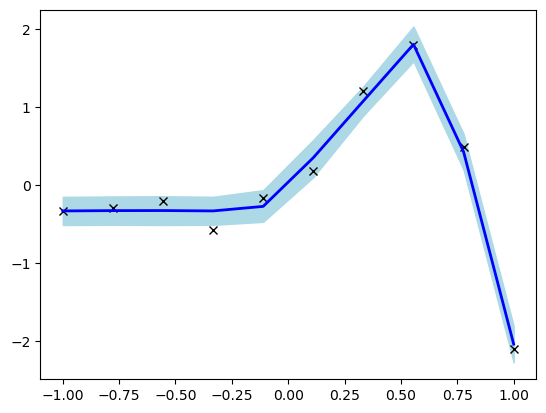

In [9]:
# make plots
#fig, ax = plt.subplots(figsize=(8, 6))

# plot training data
plt.plot(X.numpy(), Y.numpy(), "kx")
# plot 90% confidence level of predictions
plt.fill_between(
    X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
plt.plot(X.numpy().flatten(), mean_prediction, "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

#plt.savefig("bnn_plot_pyro.pdf")
plt.show()

In [12]:
#print(Y.reshape(-1))
#print(mean_prediction.reshape(-1))

X.shape

(10,)

In [46]:
def optimize(params_dict, loss_function, y, cfg, steps=500, lr=0.01):
    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr)

    total_start = time.time()

    for i in range(steps):

        optimizer.zero_grad()  # Reset gradients
        
        # loss
        current_dist = start_SOGA(cfg, params_dict, pruning='ranking')

        loss = loss_function(y, current_dist)

        # Backpropagate
        loss.backward(retain_graph=True)
        
        optimizer.step()

        # Print progress
        if i % 50 == 0:
            out = ''
            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
            out = out + f" loss: {loss.item()}"
            print(out)

    total_end = time.time()

    print('Optimization performed in ', round(total_end-total_start, 3))

In [11]:
def mean_squared_error(y_true, dist):
    return torch.mean((y_true - dist.gm.mean()) ** 2)

def mean_squared_error_bayes(y_true, dist):
    #This works for the means but of course not for the variances
    return torch.mean((y_true - dist.gm.mean()[:-2]) ** 2)

def neg_log_likelihood(y_true, dist):
    #Calculate the log-likelihood of the data given the distribution
    neg_log_likelihood = 0
    for i in range(10):
        neg_log_likelihood -= torch.log(dist.gm.marg_pdf(y_true[i].unsqueeze(0), i))
    return neg_log_likelihood

In [17]:
print(X.squeeze())
print(X.shape)

tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])
torch.Size([10, 1])


In [62]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3.soga')
cfg = produce_cfg(compiledFile)

#let's remove sigma of b3
#pars = {'muw1':0., 'sigmaw1':1., 'muw2':0., 'sigmaw2':1.,'muw3':0., 'sigmaw3':1.,'muw4':0., 'sigmaw4':1.,'mub1':0., 'sigmab1':1.,'mub2':0., 'sigmab2':1.,'mub3':0., 'sigmab3':1.}
#let's optimize only the means
#pars = {'muw1':0., 'sigmaw1':1., 'muw2':0., 'sigmaw2':1.,'muw3':0., 'sigmaw3':1.,'muw4':0., 'sigmaw4':1.,'mub1':0., 'sigmab1':1.,'mub2':0., 'sigmab2':1.,'mub3':0.}
pars = {'muw1':0., 'muw2':0.,'muw3':0.,'muw4':0.,'mub1':0.,'mub2':0.,'mub3':0.}

for key, value in pars.items():
    pars[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, pars, pruning='ranking') #params_dict 

optimize(pars, neg_log_likelihood, Y.unsqueeze(1), cfg, steps=1000, lr = 0.01)

#predictive mean
#y_pred = params_dict['muw'].detach().numpy()*X.detach().numpy()+params_dict['mub'].detach().numpy()

#predictive variance
#sigma_y_pred = np.sqrt(params_dict['sigmay'].detach().numpy()**2 + (X.detach().numpy()*params_dict['sigmaw'].detach().numpy())**2 + params_dict['sigmab'].detach().numpy()**2)



muw1: -0.009999999776482582 muw2: -0.010000000707805157 muw3: -0.009999997913837433 muw4: -0.009999997913837433 mub1: 0.009999999776482582 mub2: 0.009999999776482582 mub3: 0.009999998845160007  loss: 89.87539672851562
muw1: -0.4722413122653961 muw2: -0.47218775749206543 muw3: -0.5447949767112732 muw4: -0.5447948575019836 mub1: 0.5276546478271484 mub2: 0.5276409387588501 mub3: 0.5597163438796997  loss: 49.19328308105469
muw1: -0.0846034586429596 muw2: -0.08455074578523636 muw3: -0.7942813634872437 muw4: -0.7943506240844727 mub1: 0.7710805535316467 mub2: 0.7710342407226562 mub3: 1.1256016492843628  loss: 33.38469696044922
muw1: 0.1426064819097519 muw2: 0.14261549711227417 muw3: -1.1084599494934082 muw4: -1.108944296836853 mub1: 0.8254424333572388 mub2: 0.8251595497131348 mub3: 1.51842200756073  loss: 26.925338745117188
muw1: 0.12967926263809204 muw2: 0.12935668230056763 muw3: -1.429796814918518 muw4: -1.4311883449554443 mub1: 0.7509569525718689 mub2: 0.7503077387809753 mub3: 1.8368589878

In [63]:
output_dist = start_SOGA(cfg, pars, pruning='ranking')

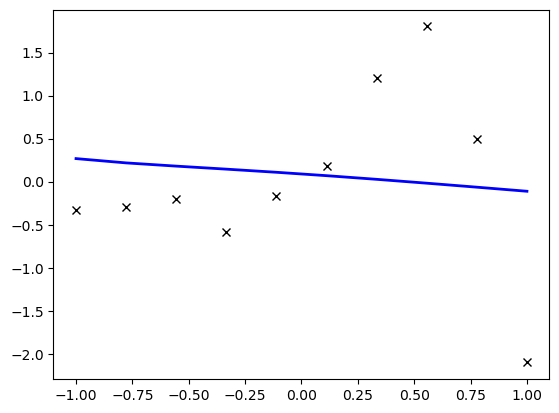

In [64]:
# plot training data
plt.plot(X.numpy(), Y.numpy(), "kx")
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), output_dist.gm.mean()[:10].detach().numpy(), "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

#plt.savefig("bnn_plot_pyro.pdf")
plt.show()


In [33]:
output_dist.gm.mean()[:10]

tensor([0.0040, 0.0035, 0.0041, 0.0048, 0.0056, 0.0063, 0.0069, 0.0073, 0.0075,
        0.0075], grad_fn=<SliceBackward0>)